# Pregnancy Habits and Child Birth Weights
_Final project from Fall 2019 Econometrics_ 

In [4]:
defaultW <- getOption("warn")
options(warn = -1)

# Load packages (mention which ones using later)
suppressMessages(library(tidyverse))
library(knitr)
suppressMessages(library(stargazer))
suppressMessages(library(gganimate))
suppressMessages(library(car))
library(estimatr)
library(texreg)

# Load dataset
data(bwght2, package='wooldridge')

# Introduction and Motivation

In 2017, around 3.86 million births were registered in the United States, which was a 2% decrease in number of births in the previous year. There are an array of variables that affect the birth of each child, and the variables being analyzed in this study fall into one of two categories: descriptive and behavioral. The descriptive category are variables that characterize the mother, father, and baby; examples for the parents would be age, years of education, and race. For the baby, examples would be their apgar score and their birth weight. The behavioral category includes variables pertaining to the mother's habits during her pregnancy; examples include attending prenatal care visits, smoking, and drinking alcoholic beverages.

A study done in 2017 showed that birth rates for women between the ages of 15-39 decreased around 2-4% (1). For non-Hispanic white women and Hispanic women, the birth rate decreased by 2-3%, whereas for non-Hispanic black women the birth rate went up a little less than 1% (1). There was an increase in the percentage of women who were getting prenatal care (77.3%), and the percentage of women who smoked decreased to 6.9% (1). With this background knowledge and using the Wooldridge dataset on birth weight (bwght2), I will investigate whether pregnancy habits such as prenatal care vists and smoking positively or negatively affects a child's birth weight, and I will also investigate whether characteristics such as age, years of education, and race positively or negatively affects a child's birth weight. 

# Data Set: bwght2

## Introduction to dataset

As mentioned previously, I will be using the Wooldridge bwght2 data set to investigate my hypotheses. bwght2 has information on the baby such as weight, apgar score, which is a score from one to ten that describes how well the baby's body handled birth (7,8,9 are considered good scores), and gender. There is also information on the mother and father such as age, years of education, and race. The data set also has information on the pregnancy such as when a mother's prenatal care began, number of alcoholic drinks consumed and cigarettes smoked during pregnancy, and the total number of prenatal visits.

I will primarily be using the variables containing information on the baby's log birth weight (lbwght), number of prenatal care visits (npvis, npvissq), the number of cigarettes smoked (cigs), parent's race (mwhte, fwhte, mblck, fblck, moth, foth), parent's age (mage, fage), and parent's years of education (meduc, feduc). These variables are adequate enough to answer the research question because there is enough variation in each of the variables to model a relationship.

For example, I had originally wanted to include the number of alcoholic beverages a woman drank during pregnancy. However, after looking at the variable drink's proportion table, I saw that 99% of the observations were 0 drinks. This meant that 99% of women in this dataset did not drink during their pregnancy, whereas 1%, or 18-19 women, had one or more drinks. A model with only 18-19 points influencing the relationship between drinks and baby weight is not sufficient. Therefore, I decided to not include alcoholic beverages in this research question. Low/very low birth weight (lbw, vlbw) also did not have enough variation to be included. However, both variables' proportions were included in the demographic proportions table below in order to give the full picture of the characteristics of the observations.

I have decided to divide the rest of the dataset analysis into two sections: descriptive variables and behavioral variables. Both sections will investigate these variables' relationship with the baby's weight.

_Dataframe with Regression Variables & Descriptive Characteristics_

In [5]:
# selecting variables from bwght2 to use in regression analysis and descriptive analysis
reg_weight <- 
    bwght2 %>% 
    rename(
        baby_weight = bwght, 
        log_weight = lbwght, 
        prenatal_visits = npvis, 
        prenatal_visits_sq = npvissq, 
        start_prenatal_visits = monpre, 
        avg_cigarettes = cigs, 
        mom_education = meduc, 
        dad_education = feduc, 
        mom_age = mage, 
        mom_age_sq = magesq, 
        dad_age = fage, 
        mom_race_white = mwhte, 
        dad_race_white = fwhte, 
        mom_race_black = mblck, 
        dad_race_black = fblck, 
        mom_race_other = moth, 
        dad_race_other = foth, 
        baby_male = male, 
        one_min_apgar = omaps, 
        five_min_apgar = fmaps, 
        low_birth_weight = lbw, 
        very_low_birth_weight = vlbw
    )

# create variables with the baby's race
reg_weight$baby_race <- rep(0, nrow(reg_weight)) %>% factor(levels=c("White", "Black", "Mixed", "Other"))
reg_weight$baby_race_white <- rep(0, nrow(reg_weight))
reg_weight$baby_race_black <- rep(0, nrow(reg_weight))
reg_weight$baby_race_other <- rep(0, nrow(reg_weight))
reg_weight$baby_race_mixed <- rep(0, nrow(reg_weight))

for(i in 1:nrow(reg_weight)) {
  if(reg_weight$mom_race_white[i] == 1 && reg_weight$dad_race_white[i] == 1) {
    reg_weight$baby_race_white[i] <- 1
    reg_weight$baby_race[i] <- "White"
  }
  else if(reg_weight$mom_race_black[i] == 1 && reg_weight$dad_race_black[i] == 1) {
    reg_weight$baby_race_black[i] <- 1
    reg_weight$baby_race[i] <- "Black"
  }
  else if(reg_weight$mom_race_other[i] == 1 && reg_weight$dad_race_other[i] == 1) {
    reg_weight$baby_race_other[i] <- 1
    reg_weight$baby_race[i] <- "Other"
  }
  else {
    reg_weight$baby_race_mixed[i] <- 1
    reg_weight$baby_race[i] <- "Mixed"
  }
}

# dataframe with mother and father information
mom_info <- data.frame(
    parent = rep("Mom", nrow(reg_weight)), 
    age = rep("NA", nrow(reg_weight)), 
    race = rep("NA", nrow(reg_weight)), 
    education = rep("NA", nrow(reg_weight)), 
    stringsAsFactors = FALSE
)
dad_info <- data.frame(
    parent = rep("Dad", nrow(reg_weight)), 
    age = rep("NA", nrow(reg_weight)), 
    race = rep("NA", nrow(reg_weight)), 
    education = rep("NA", nrow(reg_weight)), 
    stringsAsFactors = FALSE
)

# fill race variable for both
for(i in 1:nrow(reg_weight)) {
  if(reg_weight$mom_race_white[i]==1)
    mom_info$race[i] <- "White"
  else if(reg_weight$mom_race_black[i]==1)
    mom_info$race[i] <- "Black"
  else if(reg_weight$mom_race_other[i]==1)
    mom_info$race[i] <- "Other"
}

for(i in 1:nrow(reg_weight)) {
  if(reg_weight$dad_race_white[i]==1)
    dad_info$race[i] <- "White"
  else if(reg_weight$dad_race_black[i]==1)
    dad_info$race[i] <- "Black"
  else if(reg_weight$dad_race_other[i]==1)
    dad_info$race[i] <- "Other"
}

# fill education variable for both
for(i in 1:nrow(reg_weight)) {
  mom_info$education[i] <- reg_weight$mom_education[i]
  dad_info$education[i] <- reg_weight$dad_education[i]
}

# fill age variable for both
for(i in 1:nrow(reg_weight)) {
  mom_info$age[i] <- reg_weight$mom_age[i]
  dad_info$age[i] <- reg_weight$dad_age[i]
}

# combine the two dataframes and create factors
parent_info <- rbind(mom_info, dad_info)
parent_info$parent <- as.factor(parent_info$parent)
parent_info$race <- factor(parent_info$race, levels=c("White", "Black", "Other"))
parent_info$education <- as.numeric(parent_info$education)
parent_info$age <- as.numeric(parent_info$age)

# remove mom_info and dad_info from global environment
rm(mom_info, dad_info)

## Descriptive Variables Analysis 

### Baby Analysis

_Baby Demographic Average Graphs & Table_

`geom_smooth()` using formula 'y ~ x'



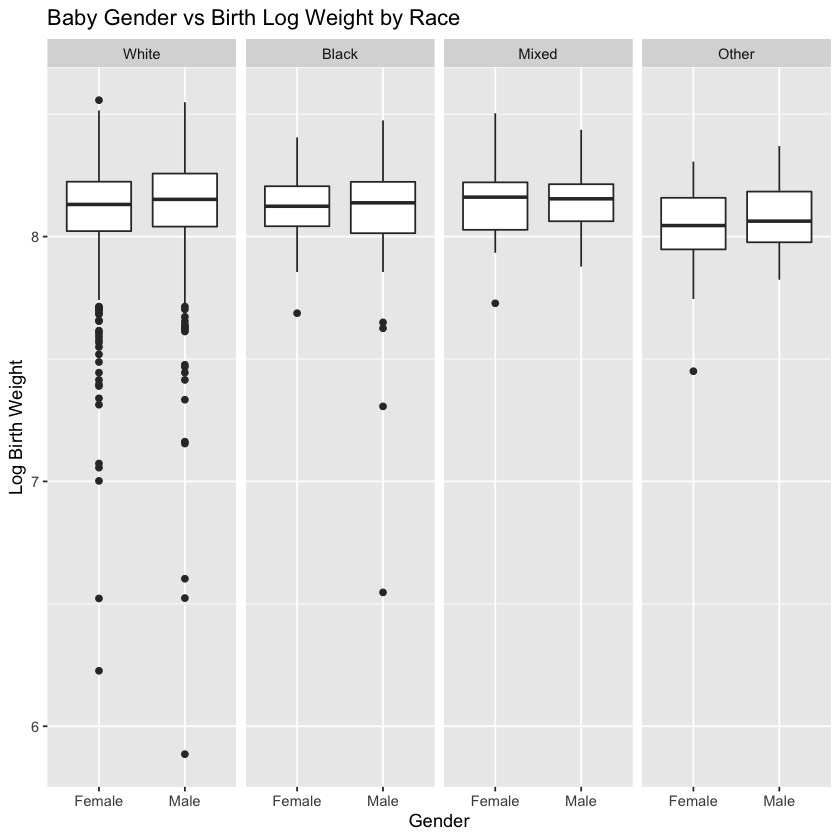

`geom_smooth()` using formula 'y ~ x'



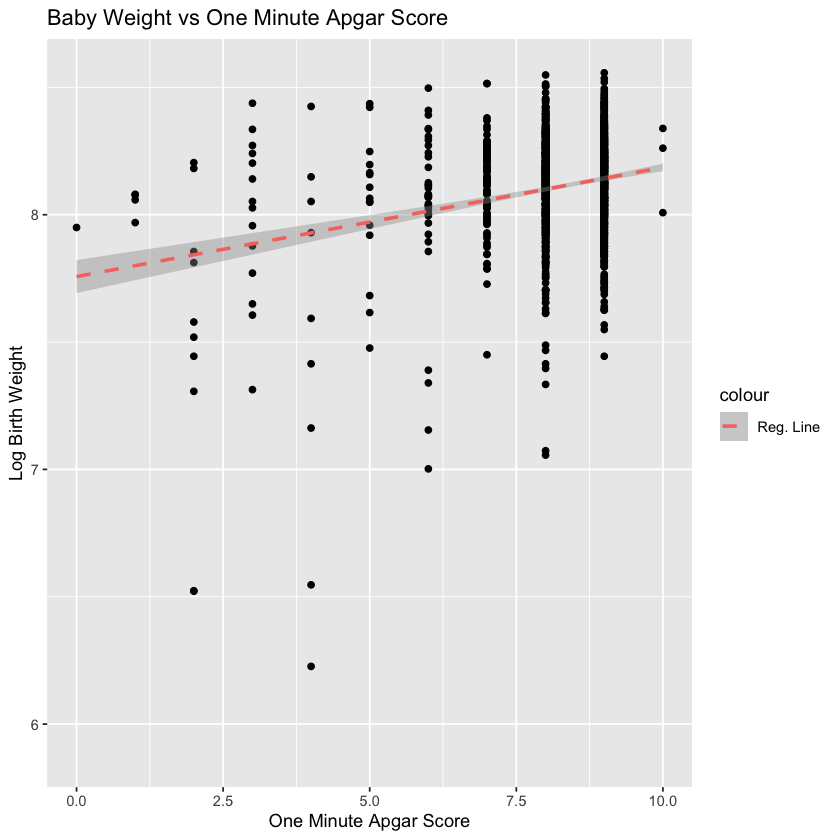



Table: Demographic of Baby

|                      |     Averages|
|:---------------------|------------:|
|Birth Weight          | 3401.1222707|
|Log Birth Weight      |    8.1142466|
|Baby Gender: Male     |    0.5136463|
|One Minute Apgar      |    8.3860033|
|Five Minute Apgar     |    9.0038272|
|Low Birth Weight      |    0.0163755|
|Very Low Birth Weight |    0.0070961|
|Race of Baby: White   |    0.8771834|
|Race of Baby: Black   |    0.0529476|
|Race of Baby: Other   |    0.0447598|
|Race of Baby: Mixed   |    0.0251092|

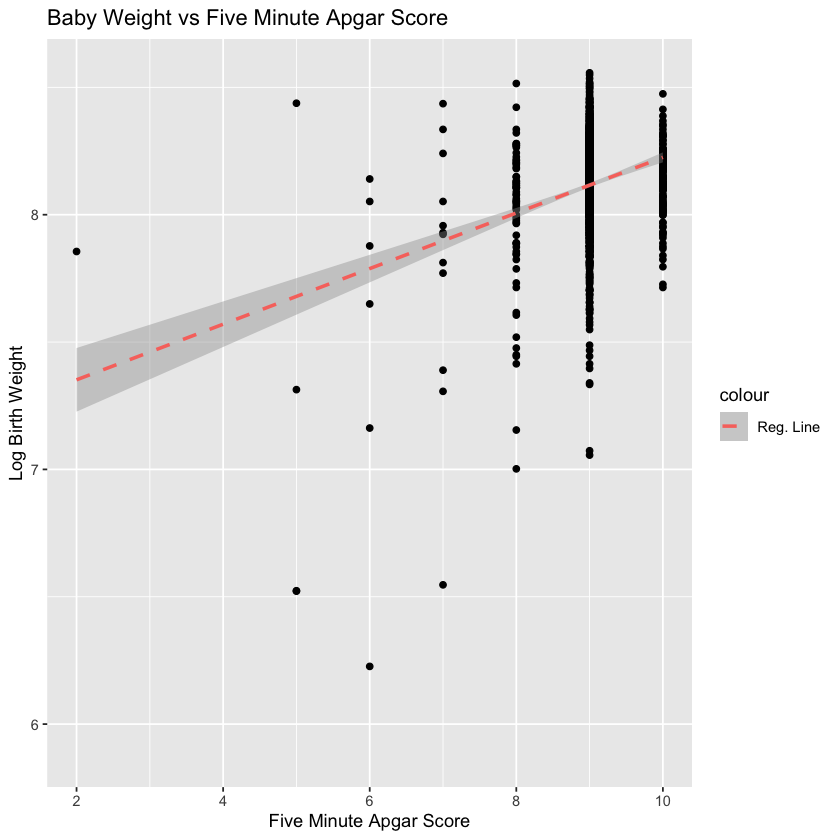

In [6]:
# baby: gender vs birth log weight
ggplot(reg_weight, aes(factor(baby_male), log_weight)) +
  geom_boxplot(na.rm=TRUE) +
  facet_grid(.~reg_weight$baby_race) +
  scale_x_discrete(labels=c("Female", "Male")) +
  ggtitle("Baby Gender vs Birth Log Weight by Race") +
  xlab("Gender") + ylab("Log Birth Weight")

# baby weight vs one minute & five minute score
ggplot(reg_weight, aes(one_min_apgar, log_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Baby Weight vs One Minute Apgar Score") +
  xlab("One Minute Apgar Score") + ylab("Log Birth Weight")

ggplot(reg_weight, aes(five_min_apgar, log_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Baby Weight vs Five Minute Apgar Score") +
  xlab("Five Minute Apgar Score") + ylab("Log Birth Weight")

# information about baby
reg_weight %>% 
    select(
        baby_weight, 
        log_weight, 
        baby_male, 
        one_min_apgar, 
        five_min_apgar, 
        low_birth_weight, 
        very_low_birth_weight, 
        baby_race_white, 
        baby_race_black, 
        baby_race_other, 
        baby_race_mixed
    ) %>% 
    rename(
        "Birth Weight" = baby_weight, 
        "Log Birth Weight" = log_weight, 
        "Baby Gender: Male" = baby_male, 
        "One Minute Apgar" = one_min_apgar, 
        "Five Minute Apgar" = five_min_apgar, 
        "Low Birth Weight" = low_birth_weight, 
        "Very Low Birth Weight" = very_low_birth_weight, 
        "Race of Baby: White" = baby_race_white, 
        "Race of Baby: Black" = baby_race_black, 
        "Race of Baby: Other" = baby_race_other, 
        "Race of Baby: Mixed" = baby_race_mixed) %>% 
    summarize_all(mean, na.rm=TRUE) %>% 
    t() %>% 
    data.frame() %>% 
    kable(col.names = c("Averages"), caption = "Demographic of Baby")

Out of 1832 baby observations, the average weight for a baby at birth is 3401 grams, or 8.12 log weight. There are around 50 more male babies (941) than female babies (891), and the majority of the babies are white (1606), compared to black (98), other (82), and mixed (46). The average one minute apgar score, which ranges between 1-10, is 8, which is considered a healthy score (Healthline Parenthood, 4). The average five minute apgar score is 9, which is expected since most babies have an increase in their apgar score at the five minute mark (Healthline Parenthood, 4). Around 30 babies were considered to have a low birth weight, and around 13 babies were considered to have a very low birth weight.

In the first baby boxplot, the baby's average log weight does not seem to change with race of baby. The white baby boxplot has more outliers, but this may be because there are more data points on babies who are white than there are babies born another race. The second and third graph shows that as the one and five minute apgar score increases, then the babies' log weight tends to increase as well. This graph follows with the notion that a higher apgar score indicates a healther baby, and a healthier baby tends to weight more at birth.

### Parent Analysis
_Mother & Father Descriptive Graphs and Table_

`geom_smooth()` using formula 'y ~ x'



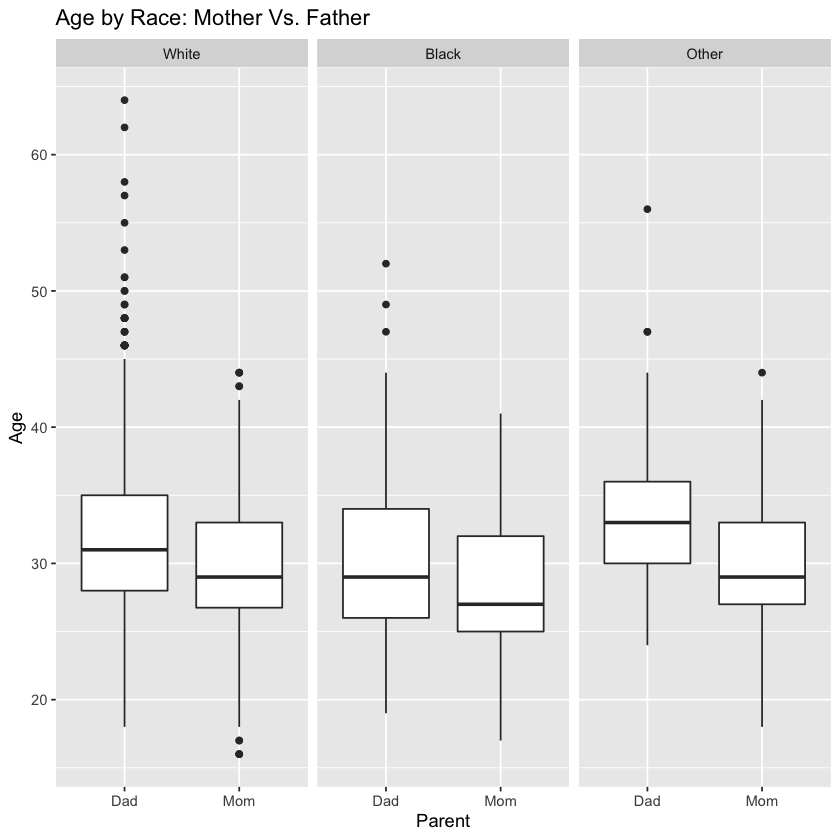

`geom_smooth()` using formula 'y ~ x'



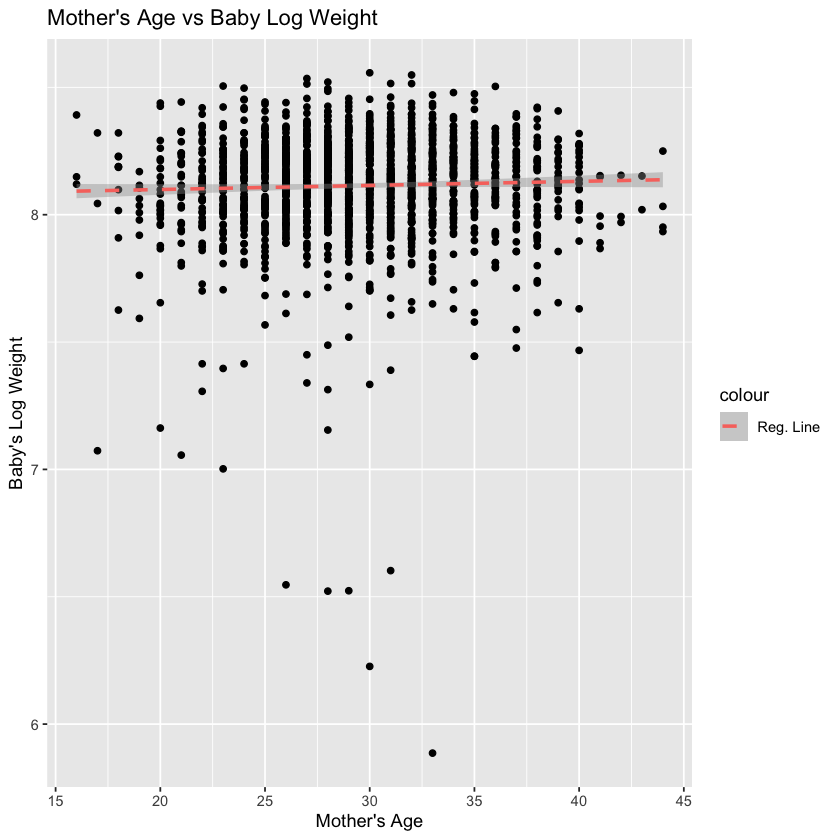

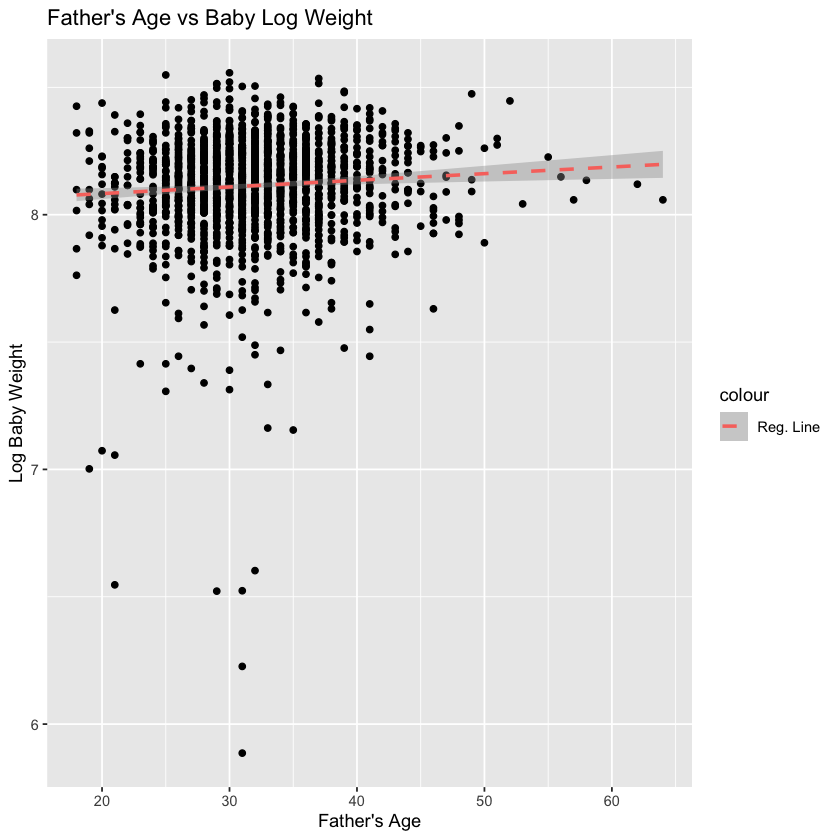

`geom_smooth()` using formula 'y ~ x'



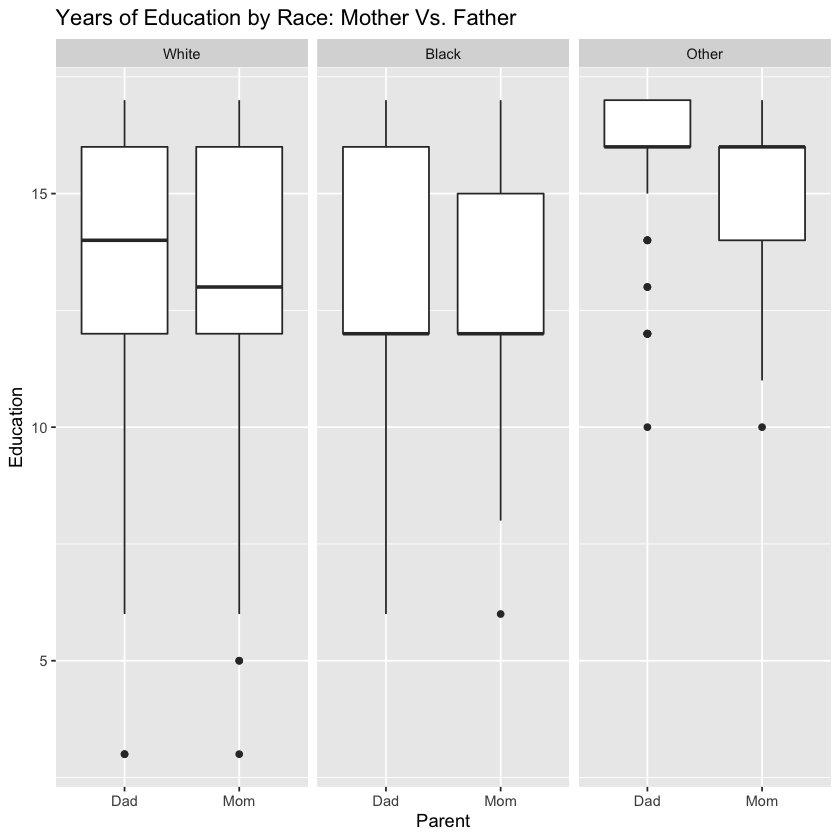

`geom_smooth()` using formula 'y ~ x'



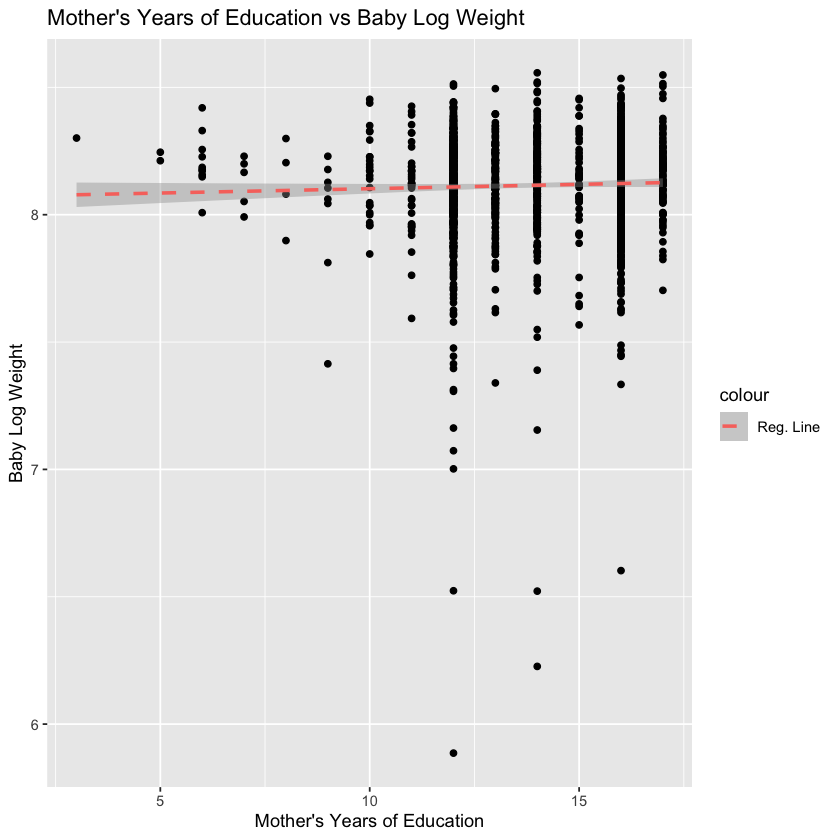



Table: Demographic of Mother

|                            |    Average|
|:---------------------------|----------:|
|Age of Mother               | 29.5578603|
|Mother's Years of Education | 13.7180910|
|Race of Mother: White       |  0.8864629|
|Race of Mother: Black       |  0.0594978|
|Race of Mother: Other       |  0.0540393|



Table: Demographic of Father

|                            |    Average|
|:---------------------------|----------:|
|Age of Father               | 31.9189485|
|Father's Years of Education | 13.9154062|
|Race of Father: White       |  0.8897380|
|Race of Father: Black       |  0.0584061|
|Race of Father: Other       |  0.0518559|

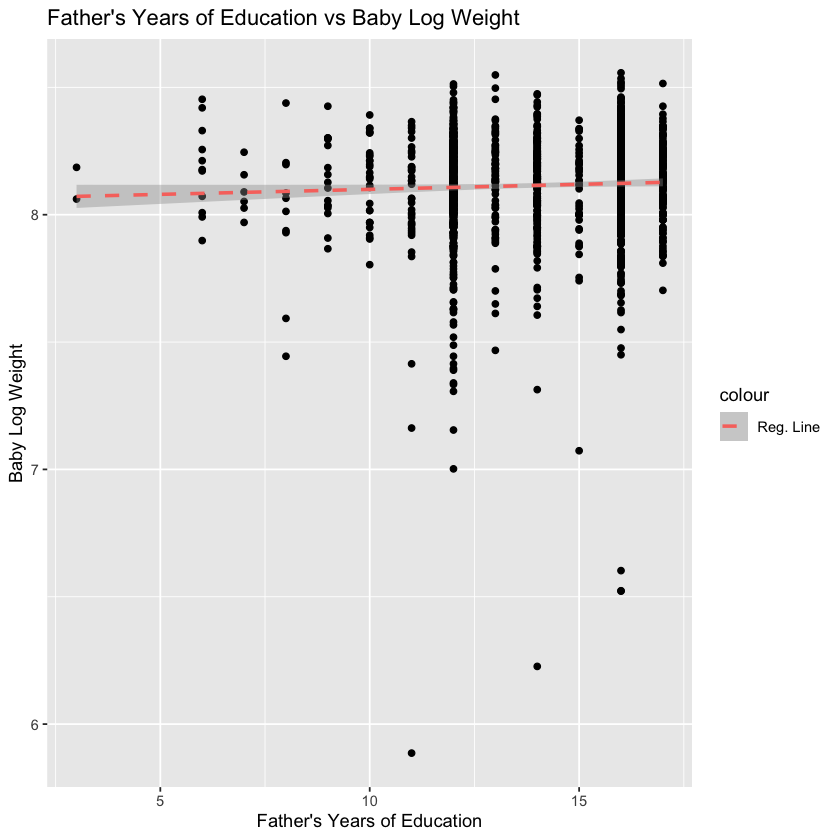

In [7]:
# age: mother vs father
ggplot(parent_info, aes(parent, age)) +
  geom_boxplot(na.rm=FALSE) +
  facet_grid(.~race) +
  ggtitle("Age by Race: Mother Vs. Father") +
  xlab("Parent") + ylab("Age")

# age and baby weight
ggplot(reg_weight, aes(mom_age, log_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Mother's Age vs Baby Log Weight") +
  xlab("Mother's Age") + ylab("Baby's Log Weight")

ggplot(reg_weight, aes(dad_age, log_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Father's Age vs Baby Log Weight") +
  xlab("Father's Age") + ylab("Log Baby Weight")
  
# years of education: mother vs father
ggplot(parent_info, aes(parent, education)) +
  geom_boxplot(na.rm=FALSE) +
  facet_grid(.~race) +
  ggtitle("Years of Education by Race: Mother Vs. Father") +
  xlab("Parent") + ylab("Education")

# years of education vs baby weight
ggplot(reg_weight, aes(mom_education, log_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Mother's Years of Education vs Baby Log Weight") +
  xlab("Mother's Years of Education") + ylab("Baby Log Weight")

ggplot(reg_weight, aes(dad_education, log_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Father's Years of Education vs Baby Log Weight") +
  xlab("Father's Years of Education") + ylab("Baby Log Weight")

# information about mother
reg_weight %>% 
    select(
        mom_age, 
        mom_education, 
        mom_race_white, 
        mom_race_black, 
        mom_race_other
    ) %>% 
    rename(
        "Age of Mother" = mom_age, 
        "Mother's Years of Education" = mom_education, 
        "Race of Mother: White" = mom_race_white, 
        "Race of Mother: Black" = mom_race_black, 
        "Race of Mother: Other" = mom_race_other) %>% 
    summarize_all(mean, na.rm=TRUE) %>% 
    t() %>% 
    data.frame() %>% 
    kable(col.names = c("Average"), caption="Demographic of Mother")

# information about father
reg_weight %>% 
    select(
        dad_age, 
        dad_education, 
        dad_race_white, 
        dad_race_black, 
        dad_race_other) %>% 
    rename(
        "Age of Father" = dad_age, 
        "Father's Years of Education" = dad_education, 
        "Race of Father: White" = dad_race_white, 
        "Race of Father: Black" = dad_race_black, 
        "Race of Father: Other" = dad_race_other) %>% 
    summarize_all(mean, na.rm=TRUE) %>% 
    t() %>% 
    data.frame() %>% 
    kable(col.names = c("Average"), caption="Demographic of Father")

On average, the mother is between 29-30 years old, whereas the father is between 31-32 years old. Both parents have an average between 13-14 years of education. There are around 1624 white mothers and 1630 white fathers, 109 black mothers and 107 black fathers, and 99 mothers and 95 fathers who identify with another race.

The first parent boxplot shows that the average age for white parents is slightly higher than black parents, but the parents who identify with another race have the oldest average age. Again, as with the baby's race, there are more observations for babies with white parents than there are for babies with parents of black or other races. For the parent's years of education, the average number of years for other race parents have the highest years of educational attainment, with white and black parents following, respectively. The graphs show that there is a very weak relationship between age/log weight and education/log weight because all the regression lines on the graphs are flat.

## Behavioral Variables Analysis
_Summary Stat and Proportion Tables_

In [9]:
# displaying summary statistics of dataset using stargazer
stargazer(
    (reg_weight %>% 
         select(
             prenatal_visits, 
             start_prenatal_visits, 
             avg_cigarettes)
    ), 
    title = "Statistical Analysis of Prenatal Habits Variables", 
    summary.stat=c("n", "mean", "sd", "min", "max"), 
    type="text"
)

# create cut points for proportion tables
pts <- c(-1,0,5,10,20,30,40)


Statistical Analysis of Prenatal Habits Variables
Statistic               N    Mean  St. Dev.  Min   Max  
--------------------------------------------------------
prenatal_visits       1,764 11.620  3.681   0.000 40.000
start_prenatal_visits 1,827 2.122   1.233   0.000 9.000 
avg_cigarettes        1,722 1.089   4.222   0.000 40.000
--------------------------------------------------------


### Prenatal Care Visits
_Prenatal Care Visits Graphs and Tables_



Table: Average Prenatal Visits

|Grouped Number of Prenatal Care Visits |      Freq|
|:--------------------------------------|---------:|
|(-1,0]                                 | 0.0028345|
|(0,5]                                  | 0.0294785|
|(5,10]                                 | 0.2998866|
|(10,20]                                | 0.6530612|
|(20,30]                                | 0.0119048|
|(30,40]                                | 0.0028345|

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



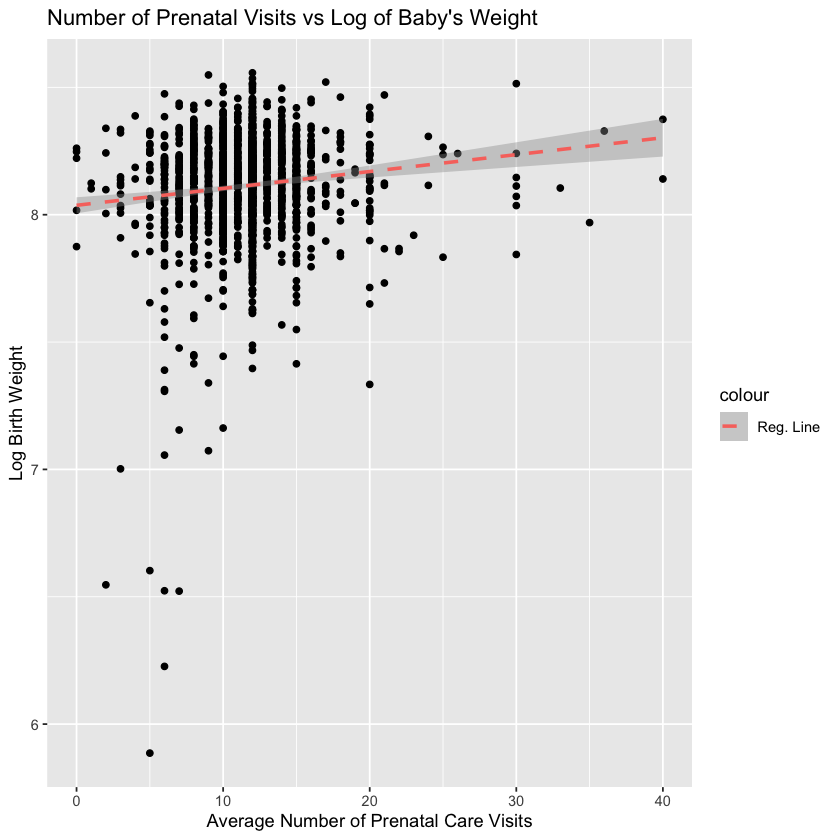

`geom_smooth()` using formula 'y ~ x'



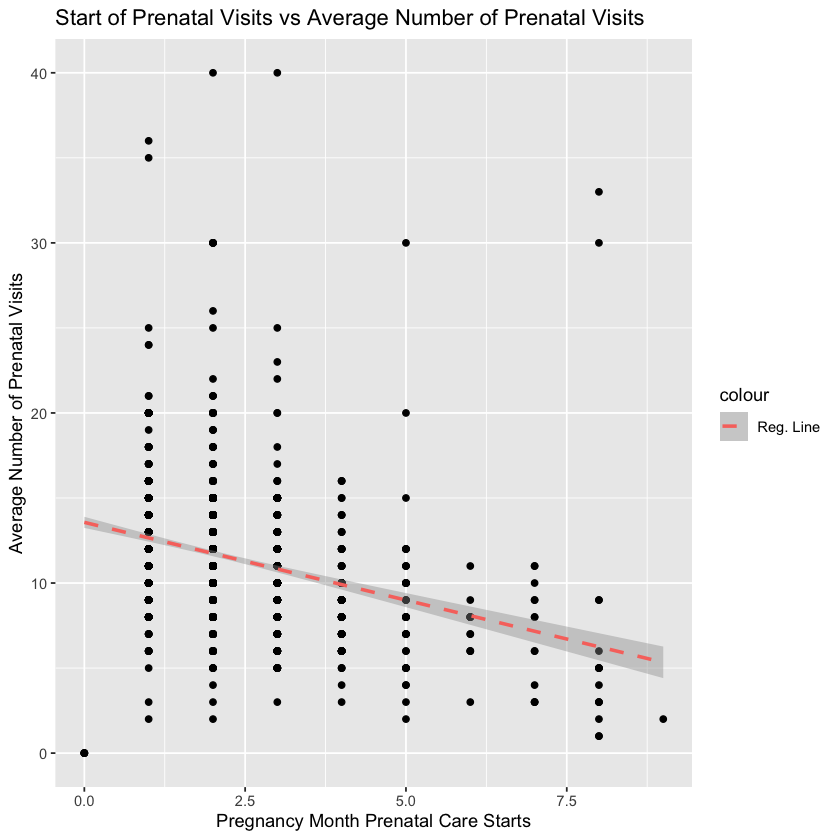

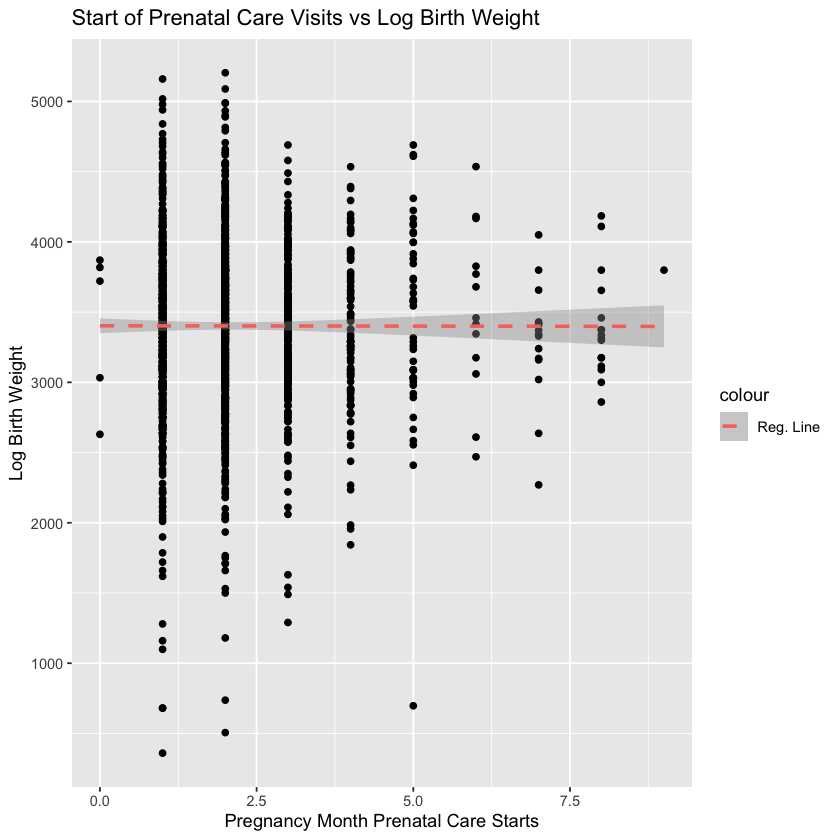

In [10]:
# proportion tables for prenatal care visits
prop.table(table(cut(reg_weight$prenatal_visits, pts))) %>% kable(caption = "Average Prenatal Visits", col.names = c("Grouped Number of Prenatal Care Visits", "Freq"))

# scatter plot of number of prenatal vists vs log of baby's weight
ggplot(reg_weight, aes(prenatal_visits, log_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line"))+
  ggtitle("Number of Prenatal Visits vs Log of Baby's Weight") +
  xlab("Average Number of Prenatal Care Visits") + ylab("Log Birth Weight")

# start prenatal visits vs number of prenatal visits
ggplot(reg_weight, aes(start_prenatal_visits, prenatal_visits)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Start of Prenatal Visits vs Average Number of Prenatal Visits") +
  xlab("Pregnancy Month Prenatal Care Starts") + ylab("Average Number of Prenatal Visits")

# start prenatal visits vs baby weight
ggplot(reg_weight, aes(start_prenatal_visits, baby_weight)) +
  geom_point(na.rm=TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line")) +
  ggtitle("Start of Prenatal Care Visits vs Log Birth Weight") +
  xlab("Pregnancy Month Prenatal Care Starts") + ylab("Log Birth Weight")

The first graph shows that the more prenatal care visits a mother has, then the higher her baby's log birth weight will be. Also, the last two graphs together show an interesting observation. The later a mother starts attending prenatal care visits, the fewer average prenatal care visits she has. This result shows that a mother will not suddenly have lots of prenatal visits in a short amount of time to make up for the time she did not have them. However, the second graph, which shows the relationship between start of prenatal care and log birth weight, shows that the relationship between the two is a flat line. This means that the start of prenatal care visits has a very minimal effect on the baby's birth weight.

### Average Cigarettes Per Day
_Average Cigarettes Graphs and Tables_



Table: Average Cigarettes

|Grouped Number of Cigarettes |      Freq|
|:----------------------------|---------:|
|(-1,0]                       | 0.9146341|
|(0,5]                        | 0.0174216|
|(5,10]                       | 0.0348432|
|(10,20]                      | 0.0278746|
|(20,30]                      | 0.0040650|
|(30,40]                      | 0.0011614|

`geom_smooth()` using formula 'y ~ x'



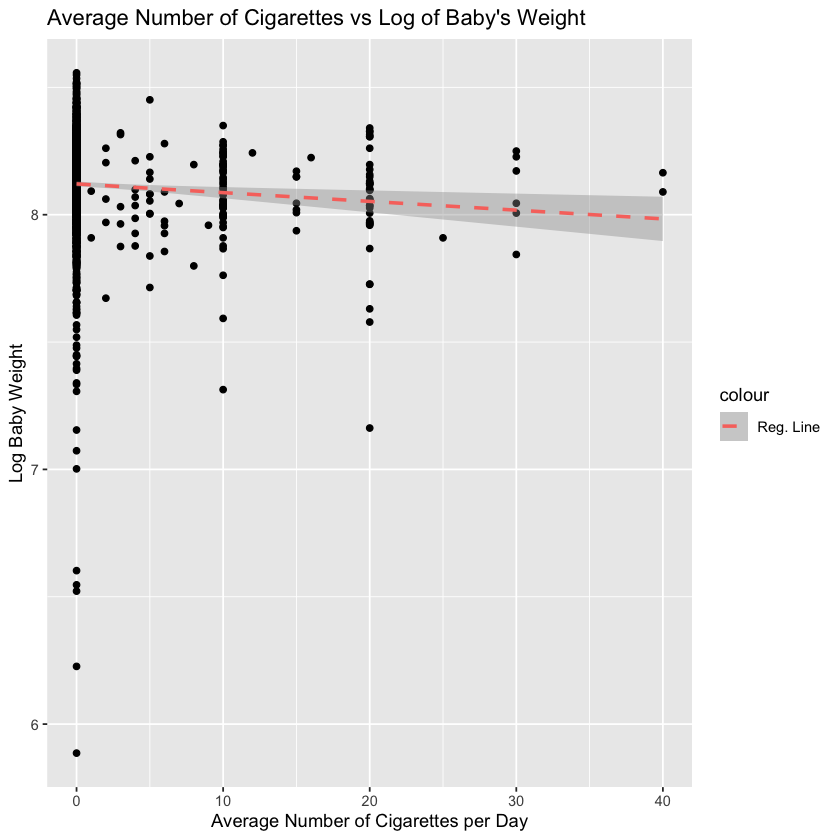

In [11]:
# proportion table of average cigarettes
prop.table(
    table(
        cut(reg_weight$avg_cigarettes, pts))
    ) %>% 
    kable(caption = "Average Cigarettes", col.names = c("Grouped Number of Cigarettes", "Freq"))

# scatter plot of average cigarettes per day vs log of baby's weight
ggplot(reg_weight, aes(avg_cigarettes, log_weight)) +
  geom_point(na.rm = TRUE) +
  geom_smooth(method="lm", se= TRUE, linetype = "dashed", na.rm=TRUE, aes(col="Reg. Line"))+
  ggtitle("Average Number of Cigarettes vs Log of Baby's Weight") +
  xlab("Average Number of Cigarettes per Day") + ylab("Log Baby Weight")

The first graph shows that the higher the average of cigarettes per day a mother has, the lower their baby's log birth weight is. Also, the proportion table shows that only 9% of mothers smoked on average one or more cigarettes per day during their pregnancy.

# Methodology/Empirical Model

## Economic Model

$$birth\_weight = f(prenatal\_vists, start\_prenatal\_visit, avg\_cigarettes, baby\_gender, parent\_education, parent\_age, parents\_race)$$

My economic model shows a relationship between the independent variables baby's gender, parent's years of education and age, number of prenatal visits, and average number cigarettes per day versus the dependent variable birth weight.

A baby's gender could influence his/her birth weight because studies have shown that males do have a higher birth weight than females, but studies have shown that the difference in birth weights between genders is decreasing (5). I hypothesize that a baby's gender does influence his/her birth weight.

It is assumed that women who are between the ages of 20-35 will birth healthier babies since studies have shown that the older a woman has her child, the more likely the baby may have birth defects. Also, highly educated women are thought to be more likely to have healthier babies since they are more likely to investiage and have healthier behaviors during pregnancy. I have not seen much literature on the effect of a father's age and years of education on the baby's weight, but I would like to investigate the possibility of a relationship in this study. The relationship could possibly come from how a father's age and years of education could influence how he himself could influence a mother during her pregnancy, but I find this to be very unlikely.

I also have not seen much literature on whether the race of the parents affects a baby's birth weight, which makes one suspect that there may not be one. However, in this analysis, I decide to test for whether the mother's and father's race is relevant in order to test all descriptive variables. Therefore, I hypothesize that a mother's age and years of education influences a baby's weight, but a father's age and years of education and the parents' race does not.

When looking at the behavioral variables, whereas preanatal care visits have been positively-associated with a healthier birth, studies have found that women who smoke during pregnancy have higher rates of babies with low-birth weights, preterm deliveries, and infant births. Therefore, I hypothesize that there will be a positive correlation between number of prenatal visits and child birth weight, and a negative correlation between number of cigarettes smoked during pregnancy and a child's birth weight.

## Econometric Models

(1) $$log\_weight = \beta_0 + \beta_1 prenatal\_visits + \beta_2 avg\_cigarettes  + u$$

This regression estimates whether only the behavioral variables, number of prenatal visits and average cigarettes, affect log birth weight, and the regression also tests whether there's solely a linear relationship between the independent and dependent variables.

(2) $$log\_weight = \beta_0 + \beta_1 prenatal\_visits + \beta_2 prenatal\_visits\_sq + \beta_3 avg\_cigarettes + u$$

This regression also only tests the behavioral variables, but it also tests whether the number of prenatal care visits has a quadratic relationship rather than a linear relationship with log birth weight.

(3) $$log\_weight = \beta_0 + \beta_1 prenatal\_visits + \beta_2 prenatal\_visits\_sq + \\ \beta_3 start\_prenatal\_visits + \beta_4 avg\_cigarettes  + u$$

I will test the addition of whether when a mother starts her prenatal care affects baby weight.

(4) $$log\_weight = \beta_0 + \beta_1 prenatal\_visits + \beta_2 prenatal\_visits\_sq + \beta_3 start\_prenatal\_visits + \\ \beta_4 avg\_cigarettes + \beta_5 baby\_male + u$$

This test also shows whether there's a relationship between a baby's gender and log weight.

(5) $$log\_weight = \beta_0 + \beta_1 prenatal\_visits + \beta_2 prenatal\_visits\_sq + \beta_3 start\_prenatal\_visits + \\ \beta_4 avg\_cigarettes + \beta_5 baby\_male + \beta_6 mom\_age + \beta_7 dad\_age+ u$$

This test will show whether the parent's age affects log weight.

(6) $$log\_weight = \beta_0 + \beta_1 prenatal\_visits + \beta_2 prenatal\_visits\_sq + \beta_3 start\_prenatal\_visits + \\ \beta_4 avg\_cigarettes + \beta_5 baby\_male + \beta_6 mom\_education + \beta_7 dad\_education+ u$$

This test will show if the parent's years of education affects log birth weight.

(7) $$log\_weight = \beta_0 + \beta_1 prenatal\_visits + \beta_2 prenatal\_visits\_sq + \beta_3 start\_prenatal\_visits + \\ \beta_4 avg\_cigarettes + \beta_5 baby\_male + \beta_6 mom\_race\_white + \beta_7 mom\_race\_black + \beta_8 dad\_race\_white + \beta_9 dad\_race\_black $$

The test will see whether the parents' race affects log birth weight, and the test uses both the mom and dad's race other as reference groups in order to avoid multicollinearity. 

# Results

## Regression Table & Discussion
_Create models and run regressions_

In [13]:
# run regressions
m1 <- lm(
    log_weight ~ prenatal_visits + avg_cigarettes, 
    data = reg_weight
)
m2 <- lm(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes, data=reg_weight
)
m3 <- lm(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits, data=reg_weight
)
m4 <- lm(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + baby_male, 
    data=reg_weight
)
m5 <- lm(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + 
    baby_male + mom_age + dad_age, 
    data = reg_weight
)
m6 <- lm(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + 
    baby_male + mom_education + dad_education, 
    data = reg_weight)
m7 <- lm(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + 
    baby_male + mom_race_white + mom_race_black + dad_race_white + dad_race_black, 
    data = reg_weight)

# stargazer table
stargazer(m1, m2, m3, m4, m5, m6, m7, type="text")


                                                                                                  Dependent variable:                                                                            
                      ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                      log_weight                                                                                 
                                (1)                      (2)                      (3)                      (4)                      (5)                     (6)                     (7)          
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
prenatal_visits              

For all models, prenatal care visits is significant at the 0.1% significance level, and it's coefficient estimate increases from 0.006 in model 1 to 0.016-0.021 in all other models when the prenatal care visit squared variable is given. Prenatal care's t-statistic also increases for model 2-6, which signifies that the prenatal care variable has a decreasing quadratic relationship; the quadratic relationships shows that, on average, for every additional prenatal care visit a mother has, the baby's log weight will decrease by 0.0003-0.0005, depending on the chosen model.

In model 1, average cigarettes is significant at the 1% significance level, but when prenatal care squared is added to the mode, significance level of average cigarettes increases to 2% significance level. For model 7, where the race of the parents is included, the significance level of average cigarettes is at 1% again, but this may be because the race of the parents has no join significance to the model (see F test). Therefore, average cigarettes is significant to the model and negatively impacts log weight.

The variable for when a mother begins attending prenatal care is significant at the 1% significance level across all models it's included in. Therefore, the variable does influence log birth weight.

The baby's gender is significant at 2% significance level, and the regression tests shows that males have a 0.024-0.027 higher log birth weight than females.

The age of a mother is not significant in model 5 but the age of the father is at the 5% significance level. However, the f-test which tests stated that age of mother and father was jointly significant at the 1% significance level. Therefore, together, the variables add more to the model than if they were separate.

Both years of education for mother and father were not significant to the model, and the f-test also showed that they were not jointly significant. The same can be said for the race of the parents' except for when the father's race is white, which is significant at the 10% significance. However, the f-test also shows that they are not jointly significance. Therefore, I would conclude that the race of the parents' is not significant.


## Inference Tests

### T-test

*Table of significance/critical values being used*

degrees of freedom | 20% (0.20) | 10% (0.10) | 5% (0.05) | 2% (0.02) | 1% (0.01) | 0.1% (0.001)
--------------------|------------|------------|-----------|-----------|-----------|---------------
 $\infty$ | 1.282 | 1.645 | 1.960 | 2.326 | 2.576 | 3.291

_table of results from t-test and p-value_

In [14]:
# t stat
data.frame(
  variables = c(
      "Intercept", "Prenatal Visit", "Prenatal Visit Squared", "Avg Cigarettes", "Start Prenatal Visits", 
      "Baby Male", "Mom Age", "Dad Age", "Mom Education", "Dad Education", "Mom Race White", "Mom Race Black", 
      "Dad Race White", "Dad Race Black"
  ),
    `Model 1` = c(
      as.numeric(summary(m1)$coefficients[,"t value"])[1:2], 
      NA, 
      as.numeric(summary(m1)$coefficients[,"t value"])[3], 
      rep(NA,10)
    ),
    `Model 2` = c(
        as.numeric(summary(m2)$coefficients[,"t value"]), 
        rep(NA,10)
    ),
    `Model 3` = c(
        as.numeric(summary(m3)$coefficients[,"t value"]), 
        rep(NA,9)
    ),
    `Model 4` = c(
        as.numeric(summary(m4)$coefficients[,"t value"]), 
        rep(NA,8)
    ),
    `Model 5` = c(
        as.numeric(summary(m5)$coefficients[,"t value"]), 
        rep(NA,6)
    ),
    `Model 6` = c(
        as.numeric(summary(m6)$coefficients[,"t value"])[1:6], 
        rep(NA,2), 
        as.numeric(summary(m6)$coefficients[,"t value"])[7:8], 
        rep(NA,4)
    ),
    `Model 7` = c(
        as.numeric(summary(m7)$coefficients[,"t value"])[1:6], 
        rep(NA,4), 
        as.numeric(summary(m7)$coefficients[,"t value"])[7:10])) %>% 
    kable(caption = "t-stat")

# p values
data.frame(
    variables = c(
        "Intercept", "Prenatal Visit", "Prenatal Visit Squared", "Avg Cigarettes", "Start Prenatal Visits", 
        "Baby Male", "Mom Age", "Dad Age", "Mom Education", "Dad Education", "Mom Race White", "Mom Race Black", 
        "Dad Race White", "Dad Race Black"
    ),
    `Model 1` = c(
        as.numeric(summary(m1)$coefficients[,"Pr(>|t|)"])[1:2], 
        NA, 
        as.numeric(summary(m1)$coefficients[,"Pr(>|t|)"])[3], 
        rep(NA,10)
    ),
    `Model 2` = c(
        as.numeric(summary(m2)$coefficients[,"Pr(>|t|)"]), 
        rep(NA,10)
    ),
    `Model 3` = c(
        as.numeric(summary(m3)$coefficients[,"Pr(>|t|)"]), 
        rep(NA,9)
    ),
    `Model 4` = c(
        as.numeric(summary(m4)$coefficients[,"Pr(>|t|)"]), 
        rep(NA,8)
    ),
    `Model 5` = c(
        as.numeric(summary(m5)$coefficients[,"Pr(>|t|)"]), 
        rep(NA,6)
    ),
    `Model 6` = c(
        as.numeric(summary(m6)$coefficients[,"Pr(>|t|)"])[1:6], 
        rep(NA,2), 
        as.numeric(summary(m6)$coefficients[,"Pr(>|t|)"])[7:8], 
        rep(NA,4)
    ),
    `Model 7` = c(
        as.numeric(summary(m7)$coefficients[,"Pr(>|t|)"])[1:6], 
        rep(NA,4), 
        as.numeric(summary(m7)$coefficients[,"Pr(>|t|)"])[7:10])) %>% 
    kable(caption = "p values")



Table: t-stat

|variables              |    Model.1|    Model.2|    Model.3|    Model.4|     Model.5|     Model.6|     Model.7|
|:----------------------|----------:|----------:|----------:|----------:|-----------:|-----------:|-----------:|
|Intercept              | 501.595295| 290.004517| 225.402679| 221.024622| 162.3335114| 154.9042400| 185.3064016|
|Prenatal Visit         |   4.289083|   4.252466|   5.053403|   5.177066|   5.1373560|   4.4476814|   5.3138091|
|Prenatal Visit Squared |         NA|  -2.919822|  -3.687278|  -3.791789|  -3.7476582|  -3.1166176|  -3.9149392|
|Avg Cigarettes         |  -2.716966|  -2.365702|  -2.547832|  -2.533477|  -2.2681598|  -1.9798743|  -2.6971887|
|Start Prenatal Visits  |         NA|         NA|   2.878780|   2.973708|   3.0985331|   3.3494568|   3.2031343|
|Baby Male              |         NA|         NA|         NA|   2.491824|   2.4309868|   2.7321665|   2.4610277|
|Mom Age                |         NA|         NA|         NA|         NA|  -0.4



Table: p values

|variables              |   Model.1|   Model.2|   Model.3|   Model.4|   Model.5|   Model.6|   Model.7|
|:----------------------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|Intercept              | 0.0000000| 0.0000000| 0.0000000| 0.0000000| 0.0000000| 0.0000000| 0.0000000|
|Prenatal Visit         | 0.0000190| 0.0000223| 0.0000005| 0.0000003| 0.0000003| 0.0000093| 0.0000001|
|Prenatal Visit Squared |        NA| 0.0035498| 0.0002340| 0.0001550| 0.0001847| 0.0018616| 0.0000941|
|Avg Cigarettes         | 0.0066571| 0.0181108| 0.0109295| 0.0113857| 0.0234489| 0.0478871| 0.0070642|
|Start Prenatal Visits  |        NA|        NA| 0.0040436| 0.0029850| 0.0019778| 0.0008283| 0.0013854|
|Baby Male              |        NA|        NA|        NA| 0.0128065| 0.0151642| 0.0063604| 0.0139560|
|Mom Age                |        NA|        NA|        NA|        NA| 0.6827666|        NA|        NA|
|Dad Age                |        NA|        NA|       

### F-test
_f-test of parents ages; education; and race_

In [15]:
# not all output showing in jupyter notebook
# test if mom_age and dad_age are jointly significant
linearHypothesis(m5, c("mom_age", "dad_age"))

# test if mom_education and dad_education are jointly significant
linearHypothesis(m6, c("mom_education", "dad_education"))

# test if mom_age and dad_age are jointly significant
linearHypothesis(m7, c("mom_race_white", "mom_race_black", "dad_race_white", "dad_race_black"))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1644,64.53683,NA,NA,NA,NA
2,1642,64.24636,2,0.2904724,3.711928,0.02463562


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1618,61.73711,NA,NA,NA,NA
2,1616,61.63020,2,0.1069158,1.401715,0.2464735


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1649,64.80385,NA,NA,NA,NA
2,1645,64.44645,4,0.3573989,2.280658,0.05857701


## Heteroskedasticity
_run regressions correcting for heteroskedasticity_

In [17]:
# create robust results in regression
rm1 <- lm_robust(
    log_weight ~ prenatal_visits + avg_cigarettes, 
    data = reg_weight) %>% 
    extract.lm_robust(include.ci = FALSE)
rm2 <- lm_robust(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes, 
    data = reg_weight) %>% 
    extract.lm_robust(include.ci = FALSE)
rm3 <- lm_robust(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits, 
    data = reg_weight) %>% 
    extract.lm_robust(include.ci = FALSE)
rm4 <- lm_robust(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + baby_male, 
    data = reg_weight) %>% 
    extract.lm_robust(include.ci = FALSE)
rm5 <- lm_robust(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + baby_male + 
    mom_age + dad_age, 
    data = reg_weight) %>% 
    extract.lm_robust(include.ci = FALSE)
rm6 <- lm_robust(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + baby_male + 
    mom_education + dad_education, 
    data = reg_weight) %>% 
    extract.lm_robust(include.ci = FALSE)
rm7 <- lm_robust(
    log_weight ~ prenatal_visits + prenatal_visits_sq + avg_cigarettes + start_prenatal_visits + baby_male + 
    mom_race_white + mom_race_black + dad_race_white + dad_race_black, 
    data = reg_weight) %>% 
    extract.lm_robust(include.ci = FALSE)

# show results in screenreg table - output not showing well in jupyter notebook
# htmlreg(list(rm1,rm2,rm3,rm4,rm5,rm6,rm7), digits = 3, doctype=FALSE)

I've added a regression table that corrects for heteroskedasticity to see if the significance level of any of the variables changed. Overall, the variables that were previously stated to be significance or not are still significant in this regression, but the level at which they are significance has changed. This is due to how heteroskedasticity corrects the variance for these variables. Most variables (avgerage cigarettes, baby gender) went from 1% significance to 5% significance. Also, in this regression, prenatal care visits squared has 5% significance and when it is added, prenatal care drops from 0.1% to 1% significance. Prenatal care visit's coefficient is also 0 across all models. Therefore, prenatal care may not have a quadratic relationship with log weight.

# Conclusion

My project has confirmed my hypothesis that a baby's gender, average number of cigarettes smoked, and prenatal care visits. The regression results do show that alone, a mother's age does not affect a baby's birth weight, but when the mother and father's age is known, then the mother's age is significant to the model. Unexpectantly, a father's age alone does slightly influence a baby's birth weight, but it has more significance when combined with a mother's age. The parents' years of education and race are not significant enough to influence the baby's birth weight. This contradicts my hypothesis that years of education is significant to the baby's weight, but the results about race do follow my hypothesis. 

For the race variable, there was a disporportional amount of white parents compared to the other races. Therefore, the analysis did not have enough data points on black or other race parents, and I believe future studies should try to include more people of color in their analysis.

Overall, the habits of a mother during pregnancy are important in order to have a baby born with a healthy birth weight, and the age of the parents are jointly significant to the model as well. 


# Bibliography & Variable Description {.tabset .tabset-fade .tabset-pills}

## Bibliography

(1) Martin, Joyce A., and Brady E. Hamilton. “Births: Final Data for 2017.” National Vital Statistics Reports, Center for Disease Control, 7 Nov. 2018, [www.cdc.gov/nchs/data/nvsr/nvsr67/nvsr67_08-508.pdf]().

(2) “Smoking During Pregnancy.” American Pregnancy Association, 8 Nov. 2019, [americanpregnancy.org/pregnancy-health/smoking-during-pregnancy/]()

(3) “Prenatal Care.” Office on Women's Health, US. Department of Health & Human Services, 1 Apr. 2019, [www.womenshealth.gov/a-z-topics/prenatal-care]().

(4) Nall, Rachel. "Apgar Score: What you should know." Healthline Parenthood. 9 Feb., 2018.  [https://www.healthline.com/health/apgar-score#apgar-rubric]()

(5) "Gender gap in birth weight strinking." The Globe and Mail. 16 Jun., 2009. [https://www.theglobeandmail.com/technology/science/gender-gap-in-birth-weight-shrinking-study-finds/article4276755/]()

## Variable Description

Below is a description of all the variables in bwght2 data set from the Wooldridge package.

Name |  Description
-----------|--------
 mage   | mother's age, years
 meduc  | mother's educ, years
 monpre  | mother prenatal care began
 npvis | total number of prenatal visits
 fage | father's age, years
 feduc  | father's educ, years
 bwght | birth weight, grams
 omaps | one minute apgar score
 fmaps | five minute apgar score
 cigs | avg cigarettes per day
 drink | avg drinks per week
 lbw | =1 if bwght <= 2000
 vlbw | =1 if bwght <= 1500
 male | =1 if baby male
 mwhte | =1 if mother white
 mblck | =1 if mother is black
 moth | =1 if mother is other
 fwhte | =1 if father white
 fblck | =1 if father black
 foth | =1 if father is other
 lbwght | log(bwght)
 magesp | mage^2
 npvissq | npvis^2